# Analyst Institute - Message Testing "Afraid" Ad - In your own Words #1

In [1]:
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from crowd_truth_amt import CrowdTruth
from itertools import combinations

import qgrid
import numpy as np

### Loading the first turk jobs for the `message_testing_afraid_ad_saying_in_your_words` survey items

In [2]:
ai_afraid_ad_own_words_1_path = 'analyst_institute_afraid_ad_message_testing_saying_in_your_own_words_1.csv'
ct = CrowdTruth(df=ai_afraid_ad_own_words_1_path)

# Reviewing Workers

## *Asymmetric Worker-Worker Agreement*
For workers, $a$ and $b$, it is the number of times that $a$ and $b$ provided the same label for the same item divided by the total number of items that $a$ provided.

***What it's good for***: This measure allows us to determine whether a pair of annotators have given the same response on a suspiciously high number of items. This can happen when turk workers have multiple accounts open for the same HITs and use this to double the amount of money they make. It's important to note that this is likely not much of an issue for us since we filter Turk workers for quality before allowing them into the task, so this measure will likely not get used much.

***What to look for***: The more items that two annotators have in common, the less likely they are to have nearly perfect alignment. Look for workers who have labeled many things together AND still have a high agreement score.

In [3]:
worker_ids = ct.get_all_worker_ids()

In [4]:
worker_combos = list(combinations(worker_ids, 2))

worker_agreements = []

for wid1, wid2 in tqdm(worker_combos):
    w_df1 = ct.get_worker_df(wid1)
    w_df2 = ct.get_worker_df(wid2)
    items_in_common = ct.items_in_common(w_df1, w_df2)
    result1 = {'wid1':wid1,
              'wid2':wid2,
              'agreement':ct.asym_worker_agreement(w_df1, w_df2),
              'n_common':items_in_common}
    result2 = {'wid1':wid2,
              'wid2':wid1,
              'agreement':ct.asym_worker_agreement(w_df2, w_df1),
              'n_common':items_in_common}
    worker_agreements.append(result1)
    worker_agreements.append(result2)
    
worker_agr_df = pd.DataFrame(worker_agreements)
qgrid.show_grid(worker_agr_df.sort_values(by=['agreement', 'n_common'], ascending=[False, False]))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Worker-Item Similarity
*worker-item similarity* is how close a worker's responses are to the aggregate of everyone else's responses

$$\text{worker-item similarity}(w) = \text{cosine similarity}(w_i, V_i)$$

$$w = \text{the worker}$$

$$w_i = \text{The label vector that worker $w$ provided to item, $i$}$$

$$V_i = \text{The sum of all label vectors provided by all workers for item, $i$}$$

In [5]:
results = []

for wid in tqdm(worker_ids, desc='Workers'):
    w_df = ct.get_worker_df(wid)
    
    worker_item_sims = ct.get_worker_item_sims(w_df)
    
    result = {'wid':wid,
              'avg_sim': worker_item_sims.mean(),
              'stdev_sim': worker_item_sims.std(),
              'num_annotations': len(worker_item_sims)}
    results.append(result)
    
results_df = pd.DataFrame(results).set_index('wid')
qgrid.show_grid(results_df.sort_values(by=['avg_sim', 'stdev_sim', 'num_annotations'], \
                                       ascending=[True, True,False]))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Reviewing specific workers

### Display a distribution plot of the labels a worker provided

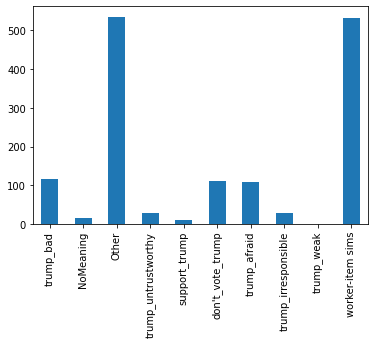

In [6]:
w_df = ct.get_worker_df('AEF601SQFOSBL')
w_df = w_df[w_df.sum(axis=1) > 0]
item_ids = list(w_df.index)
w_item_sims = pd.DataFrame([ct.worker_item_sim(w_df, item_id) for item_id in item_ids], index=item_ids, columns=['worker-item sims'])

w_df = pd.merge(w_df, w_item_sims, left_index=True, right_index=True)
w_df.sum(axis=0).plot(kind='bar')

### Removing a Worker
If a worker has systematically provided low quality answers, we can remove them with the following steps:
1. update `CrowdTruth.df` by removing the worker
2. recompute `clarity_df` with `CrowdTruth.compute_clarity_df(df)`

In this example, we'll remove worker #3 because they have a very low *worker-item score* AND they labeled a lot of items so this low score has a big influence
on the quality of the dataset.

In [7]:
ct.df = ct.df[ct.df['WorkerId'] != 3]
ct.clarity_df = ct.compute_clarity_df(ct.df)

Now when we review the workers again, we see that the numbers have changed to reflect the absence of worker #3

In [8]:
results = []
worker_ids = ct.get_all_worker_ids()

for wid in tqdm(worker_ids, desc='Workers'):
    w_df = ct.get_worker_df(wid)
    
    worker_item_sims = ct.get_worker_item_sims(w_df)
    
    result = {'wid':wid,
              'avg_sim': worker_item_sims.mean(),
              'stdev_sim': worker_item_sims.std(),
              'num_annotations': len(worker_item_sims)}
    results.append(result)
    
results_df = pd.DataFrame(results).set_index('wid')
qgrid.show_grid(results_df.sort_values(by=['avg_sim', 'stdev_sim', 'num_annotations'], \
                                       ascending=[True, True,False]))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

***NOTE***: Sometimes when a `0` or `NaN` value is given for `avg_sim` it is the result of the worker's contributions having no
overlap with other workers.

# Reviewing Themes / Relations

## Relation Corroboration Scores
The Relation Corroboration score is the number of times that a relation was applied *AND* corroborated by at least $x$ other annotators divided by the overall
number of times that the relation was applied.

$$\frac{\text{number of times the label was corroborated}}{\text{total number of times the label was applied}}$$

This metric allows us to better understand when a theme is clear enough that when it is applied, it is likely that another $x$ annotators will agree that this was a 
good choice.

In [9]:
ct.get_theme_corroboration_scores()

trump_afraid           0.925373
trump_irresponsible    0.836364
don't_vote_trump       0.825243
trump_untrustworthy    0.781818
trump_bad              0.722555
Other                  0.710188
NoMeaning              0.647541
support_trump          0.585586
trump_weak             0.280000
dtype: float64

## Theme Association Rules

Theme Association Rules are items that appear regularly with each other. It leverages the *apriori* algorithm for association rule mining. We can use this to better understand what themes are being applied regularly with other themes to understand if annotators are effectively distinguishing between themes that should be 
clearly distinguishable. This can also be used to identify scenarios in which a theme should be a subset of another theme meaning that every time the subtheme is applied,
it is implied that the supertheme applies as well.

In [10]:
ct.get_theme_association_rules().head()

,X,Y,confidence
0,"(support_trump,)","(Other,)",0.823529
1,"(don't_vote_trump,)","(Other,)",0.429658
2,"(NoMeaning,)","(Other,)",0.789474


## Relation Clarity Scores
The relation clarity score tells us the most a relation/theme ever uniquely described an item. In our current workflow, we often assume that an item is likely to have more than 1 of the nearly 20 or so themes that are often being applied, so a metric that only tells us how well a relation was every uniquely applied is not helpful as a universal metric for assessing themes. However, it does help us to review relation that we believe *should* be uniquely describing an item. This especially important for non-theme relations like ***NoMeaning***, because we would expect that if we are certain that there is no meaning to a post, then we should not also be choosing a relation that *has meaning*.

In [11]:
ct.relation_clarity_scores().sort_values(by='rel_clarity (mean)', ascending=False)

,rel_clarity (max),rel_clarity (mean),rel_clarity (StDev),num_annotations
Other,1.00,0.335285,0.357632,1011.0
don't_vote_trump,1.00,0.158412,0.296521,515.0
trump_bad,1.00,0.150712,0.278969,501.0
trump_afraid,1.00,0.139736,0.301642,469.0
support_trump,1.00,0.072205,0.185528,222.0
trump_irresponsible,1.00,0.047602,0.176295,165.0
NoMeaning,1.00,0.041202,0.159204,122.0
trump_untrustworthy,1.00,0.033502,0.148681,110.0
trump_weak,0.75,0.021344,0.089194,75.0


# Reviewing Items

## *Item Corroboration Score*'
the number of times a label was corroborated for an item divided by the total number of labels

In [12]:
pd.merge(ct.get_item_corroboration_scores().to_frame(name='corroboration'), ct.responses.to_frame(name='response'), left_index=True, right_index=True)

,corroboration,response
301KG0KX9DZJQ5F4XJZ78S503L6H2A,0.000000,It is an ad campaign designed to bash trump.
301KG0KX9DZJQ5F4XJZ78S503L72HW,0.666667,Things didn't have to be the way they are. We ...
302OLP89D0LHE0ZSO6EL3JRI2HTAC1,0.666667,No matter how hard they have to distort realit...
302OLP89D0LHE0ZSO6EL3JRI2HTCA3,1.000000,He doesn't take responsibility for his actions.
302U8RURJ0FKXSZHOREVFHZ7MV8NVX,1.000000,be safe
...,...,...
3ZXNP4Z39SZSY2V0UGV0WBFFVI1L71,0.666667,Fake media will continue lying about the truth
3ZXV7Q5FJC2CARG0ZM0DHK29ZX6CFG,0.666667,who the best president would be
3ZXV7Q5FJC2CARG0ZM0DHK29ZX6FCJ,1.000000,Trump is a bad leader
3ZZAYRN1I75N2LV4KBETTOBRFKXOTX,0.666667,Smndjdjd


## *Item-Relation Score*
This is the proportion of votes for a relation to apply to a theme. Similar to the issues with the Theme clarity score, Item-Relation Scores mostly help us to understand
when a relation *uniquely* describes an item, not when a relation describes an item well.

In [13]:
item_rel_df = ct.get_item_relation_scores()
item_rel_df.head()

,trump_bad,NoMeaning,Other,trump_untrustworthy,support_trump,don't_vote_trump,trump_afraid,trump_irresponsible,trump_weak
HITId,,,,,,,,,
301KG0KX9DZJQ5F4XJZ78S503L6H2A,0.333333,0.0,0.333333,0.0,0.333333,0.000000,0.0,0.0,0.0
301KG0KX9DZJQ5F4XJZ78S503L72HW,0.000000,0.0,0.666667,0.0,0.000000,0.333333,0.0,0.0,0.0
302OLP89D0LHE0ZSO6EL3JRI2HTAC1,0.000000,0.0,0.333333,0.0,0.666667,0.000000,0.0,0.0,0.0
302OLP89D0LHE0ZSO6EL3JRI2HTCA3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0
302U8RURJ0FKXSZHOREVFHZ7MV8NVX,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


### *Item-Clarity*
The maximum item-relation score for an item.

***Caveat***: Item clarity assumes that what we want is for a relation/theme to singularly represent an item. Ideally, we would use a metric that provides an equally high score for an item that has 1 clear label as it does for an item that has 2 clear items.

In [14]:
item_rel_df.loc['301KG0KX9DZJQ5F4XJZ78S503L6H2A']

trump_bad              0.333333
NoMeaning              0.000000
Other                  0.333333
trump_untrustworthy    0.000000
support_trump          0.333333
don't_vote_trump       0.000000
trump_afraid           0.000000
trump_irresponsible    0.000000
trump_weak             0.000000
Name: 301KG0KX9DZJQ5F4XJZ78S503L6H2A, dtype: float64